In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from omegaconf import OmegaConf
import torch
from collections import defaultdict
import wandb
from types import SimpleNamespace
import sys
import os

# Add the path to A_1/ relative to the notebook
base_path = os.path.abspath(os.path.join('../..'))
sys.path.append(base_path)
colors = OmegaConf.load('../colors.yml')

from src.utils.model_utils import vbll_model_factory

In [2]:
args = OmegaConf.load('../../config.yml')
api = wandb.Api()
config = api.run(f"{args.wandb.entity}/{args.wandb.project}/{args.wandb.run_id}").config
params = SimpleNamespace(**config)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = f"../../output/models/{args.wandb.run_id}"
model_path = f"{save_dir}/model.pt"

tokenizer, model = vbll_model_factory(params.model_name, device)
method = "vbll"

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
pass

/Users/oliverneut/miniconda3/envs/bret/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
data = defaultdict(dict)

with open('../../data/dl-typo/query.tsv', 'r') as f:
    for line in f:
        qid, query = line.strip().split('\t')
        data[qid]['clean'] = query

with open('../../data/dl-typo/query.typo.tsv', 'r') as f:
    for line in f:
        qid, query = line.strip().split('\t')
        data[qid]['typo'] = query

In [13]:
def infer_query(qry: str, tokenizer, model):
    qry_enc = tokenizer(qry, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
    qry_emb = model(qry_enc)
    return qry_emb

def uncertainty_score(qry_emb, unc_method="norm"):
    cov = qry_emb.covariance.squeeze()

    if unc_method == "norm":
        return torch.sqrt(qry_emb.trace_covariance)
    elif unc_method == "trace":
        return qry_emb.trace_covariance
    elif unc_method == "det":
        return qry_emb.logdet_covariance
    elif unc_method == "entropy":
        d = cov.size(0)
        logdet = qry_emb.logdet_covariance
        return 0.5 * d * torch.log(torch.tensor(2 * torch.pi * torch.e)) + 0.5 * logdet
    else:
        raise ValueError(f"Unknown uncertainty method: {unc_method}")

In [6]:
def calculate_uncertainty_scores(data, tokenizer, model, unc_method="norm"):
    clean_uncs, typo_uncs = [], []
    diff_uncs = []
    for qid, queries in data.items():        
        clean_emb = infer_query(queries['clean'], tokenizer, model)
        typo_emb = infer_query(queries['typo'], tokenizer, model)
        
        clean_unc = uncertainty_score(clean_emb.predictive, unc_method).item()
        typo_unc = uncertainty_score(typo_emb.predictive, unc_method).item()
        clean_uncs.append(clean_unc)
        typo_uncs.append(typo_unc)
        diff_uncs.append(clean_unc - typo_unc)

    return clean_uncs, typo_uncs, diff_uncs

In [17]:
def visualize_histograms(clean_uncs, typo_uncs, unc_method):
    _, ax = plt.subplots(figsize=(8, 6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Step 2: Plot histograms
    _, bins1, _ = ax.hist(clean_uncs, color=colors.red.light, bins=15, density=True, linewidth=1.5,
                                    alpha=0.7, edgecolor=colors.red.mid, label='clean')
    _, bins2, _ = ax.hist(typo_uncs, color=colors.blue.light, bins=15, density=True, linewidth=1.5,
                                    alpha=0.7, edgecolor=colors.blue.mid, label='typo')

    mu1, sigma1 = np.mean(clean_uncs), np.std(clean_uncs)
    mu2, sigma2 = np.mean(typo_uncs), np.std(typo_uncs)

    x1 = np.linspace(min(bins1), max(bins1), 1000)
    pdf1 = norm.pdf(x1, mu1, sigma1)
    ax.plot(x1, pdf1, '-', color=colors.red.dark, linewidth=1.5)
    ax.axvline(mu1, color=colors.red.dark, linestyle='--', linewidth=1.5)


    x2 = np.linspace(min(bins2), max(bins2), 1000)
    pdf2 = norm.pdf(x2, mu2, sigma2)
    ax.plot(x2, pdf2, '-',color=colors.blue.dark, linewidth=1.5)
    ax.axvline(mu2, color=colors.blue.dark, linestyle='--', linewidth=1.5)

    ax.legend()
    
    plt.savefig(f'../figures/ood/typo_histogram_{unc_method}.png', dpi=300, bbox_inches='tight')

In [18]:
def visualize_histogram(diff_uncs, unc_method):
    _, ax = plt.subplots(figsize=(8, 6))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Step 2: Plot histogram
    _, bins, _ = ax.hist(diff_uncs, color=colors.grey.light, bins=15, density=True, linewidth=1.5,
                                    alpha=0.7, edgecolor=colors.grey.mid)

    mu, sigma = np.mean(diff_uncs), np.std(diff_uncs)

    x = np.linspace(min(bins), max(bins), 1000)
    pdf = norm.pdf(x, mu, sigma)
    ax.plot(x, pdf, '-', color=colors.grey.dark, linewidth=1.5)
    ax.axvline(mu, color=colors.grey.dark, linestyle='--', linewidth=1.5)

    plt.savefig(f'../figures/ood/typo_histogram_diff_{unc_method}.png', dpi=300, bbox_inches='tight')

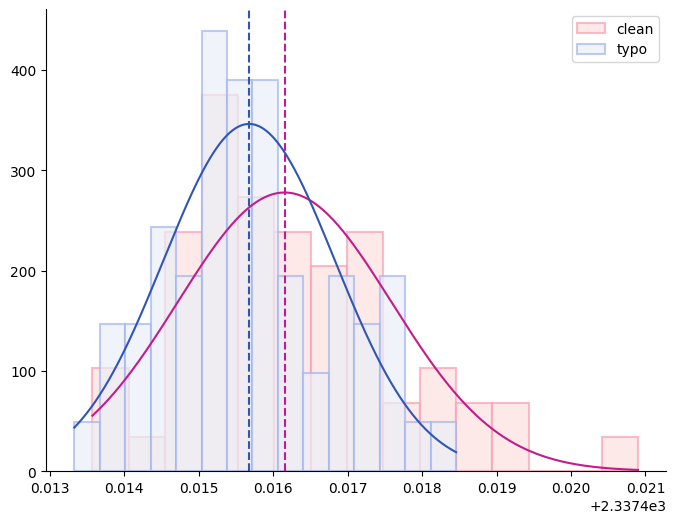

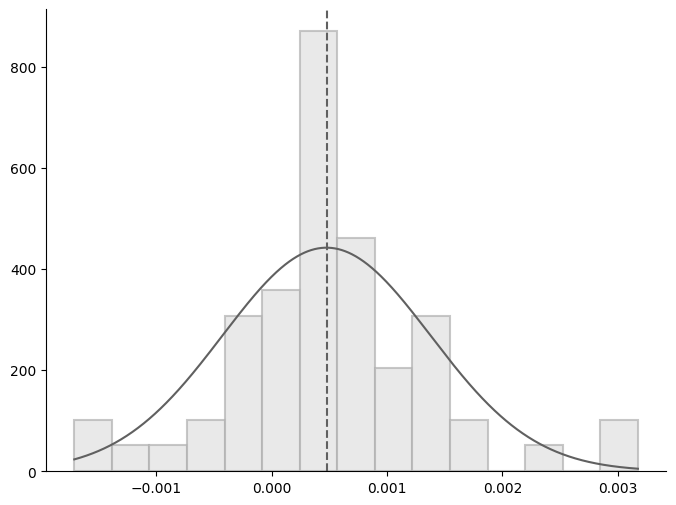

In [19]:
unc_method = "norm"
clean_uncs, typo_uncs, diff_uncs = calculate_uncertainty_scores(data, tokenizer, model, unc_method=unc_method)
visualize_histograms(clean_uncs, typo_uncs, unc_method=unc_method)
visualize_histogram(diff_uncs, unc_method=unc_method)

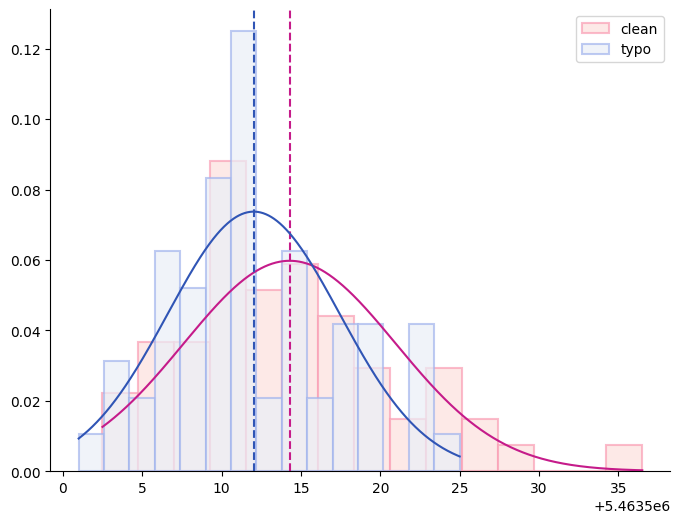

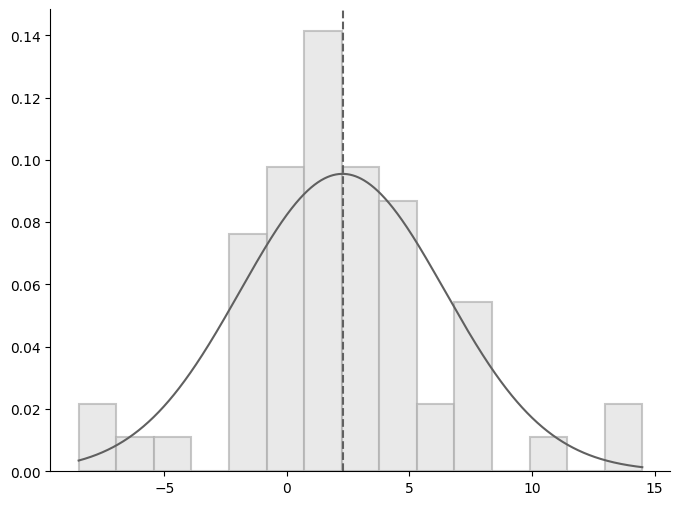

In [10]:
unc_method = "trace"
clean_uncs, typo_uncs, diff_uncs = calculate_uncertainty_scores(data, tokenizer, model, unc_method=unc_method)
visualize_histograms(clean_uncs, typo_uncs, unc_method=unc_method)
visualize_histogram(diff_uncs, unc_method=unc_method)

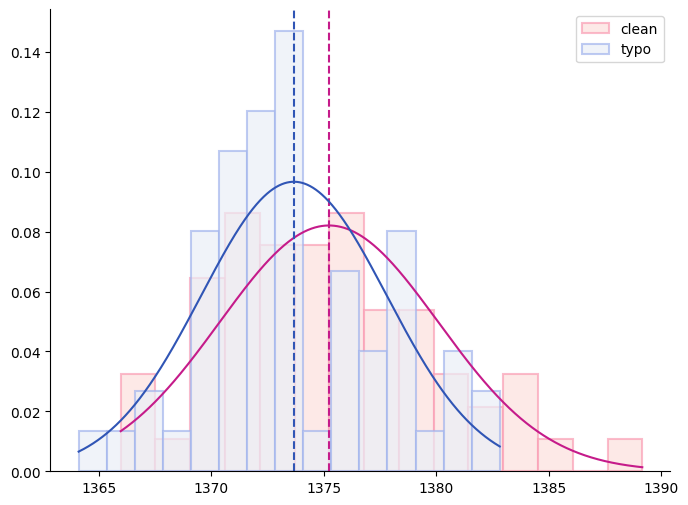

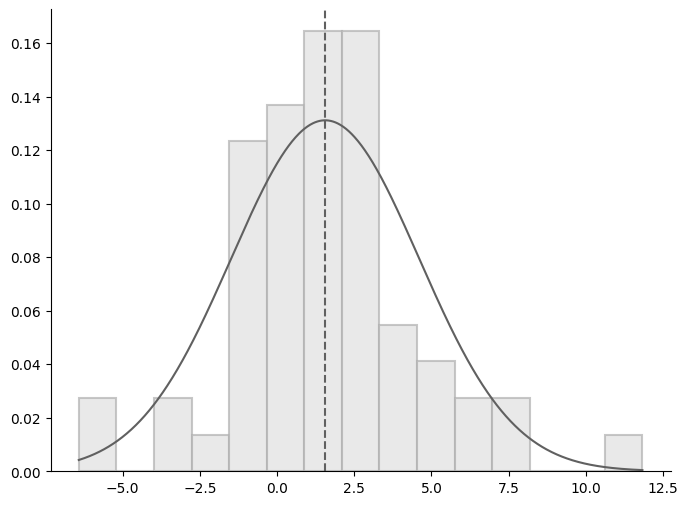

In [11]:
unc_method = "det"
clean_uncs, typo_uncs, diff_uncs = calculate_uncertainty_scores(data, tokenizer, model, unc_method=unc_method)
visualize_histograms(clean_uncs, typo_uncs, unc_method=unc_method)
visualize_histogram(diff_uncs, unc_method=unc_method)

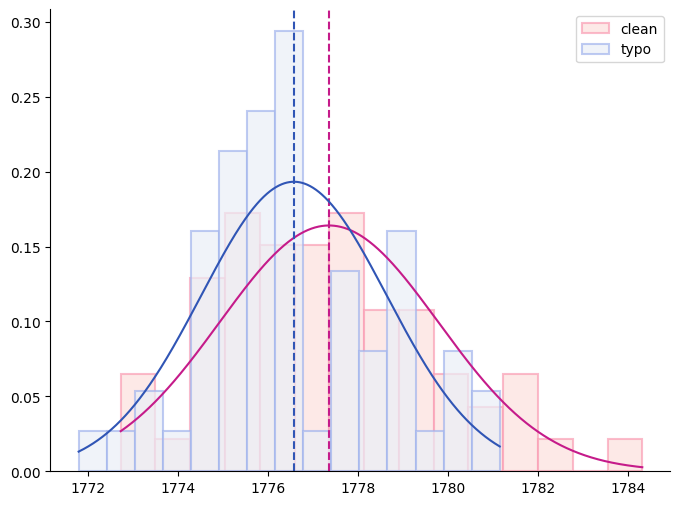

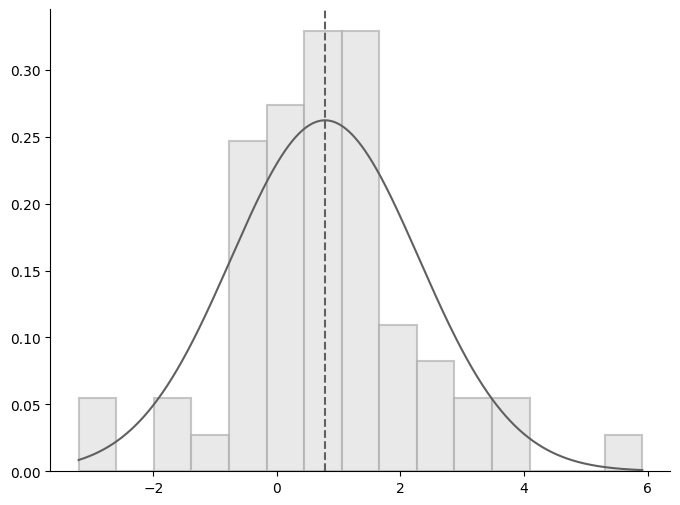

In [12]:
unc_method = "entropy"
clean_uncs, typo_uncs, diff_uncs = calculate_uncertainty_scores(data, tokenizer, model, unc_method=unc_method)
visualize_histograms(clean_uncs, typo_uncs, unc_method=unc_method)
visualize_histogram(diff_uncs, unc_method=unc_method)